In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# DATASET

In [15]:
iris = sns.load_dataset("iris")
# augment
iris["species_is_virginica"] = iris["species"] == "virginica"
iris["species_is_virginica_as_int"] = iris["species_is_virginica"].astype(int)

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species_is_virginica,species_is_virginica_as_int
0,5.1,3.5,1.4,0.2,setosa,False,0
1,4.9,3.0,1.4,0.2,setosa,False,0
2,4.7,3.2,1.3,0.2,setosa,False,0
3,4.6,3.1,1.5,0.2,setosa,False,0
4,5.0,3.6,1.4,0.2,setosa,False,0


In [16]:
iris.dtypes

sepal_length                   float64
sepal_width                    float64
petal_length                   float64
petal_width                    float64
species                         object
species_is_virginica              bool
species_is_virginica_as_int      int64
dtype: object

In [17]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width,species_is_virginica_as_int
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,0.333333
std,0.828066,0.435866,1.765298,0.762238,0.472984
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,0.000000
75%,6.400000,3.300000,5.100000,1.800000,1.000000
max,7.900000,4.400000,6.900000,2.500000,1.000000


In [18]:
iris["species"].value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

In [19]:
iris["species_is_virginica"].mean()

0.3333333333333333

## Nulls, Outliers, Inliers (harder to detect, but also lower Cook's distance)

Once you understand it, ways to handle:
* drop or re-record column (bad-quality data)
* drop row(s) (do rarely!!!)
* impute with a flag

In [20]:
iris.isna().mean()

sepal_length                   0.0
sepal_width                    0.0
petal_length                   0.0
petal_width                    0.0
species                        0.0
species_is_virginica           0.0
species_is_virginica_as_int    0.0
dtype: float64

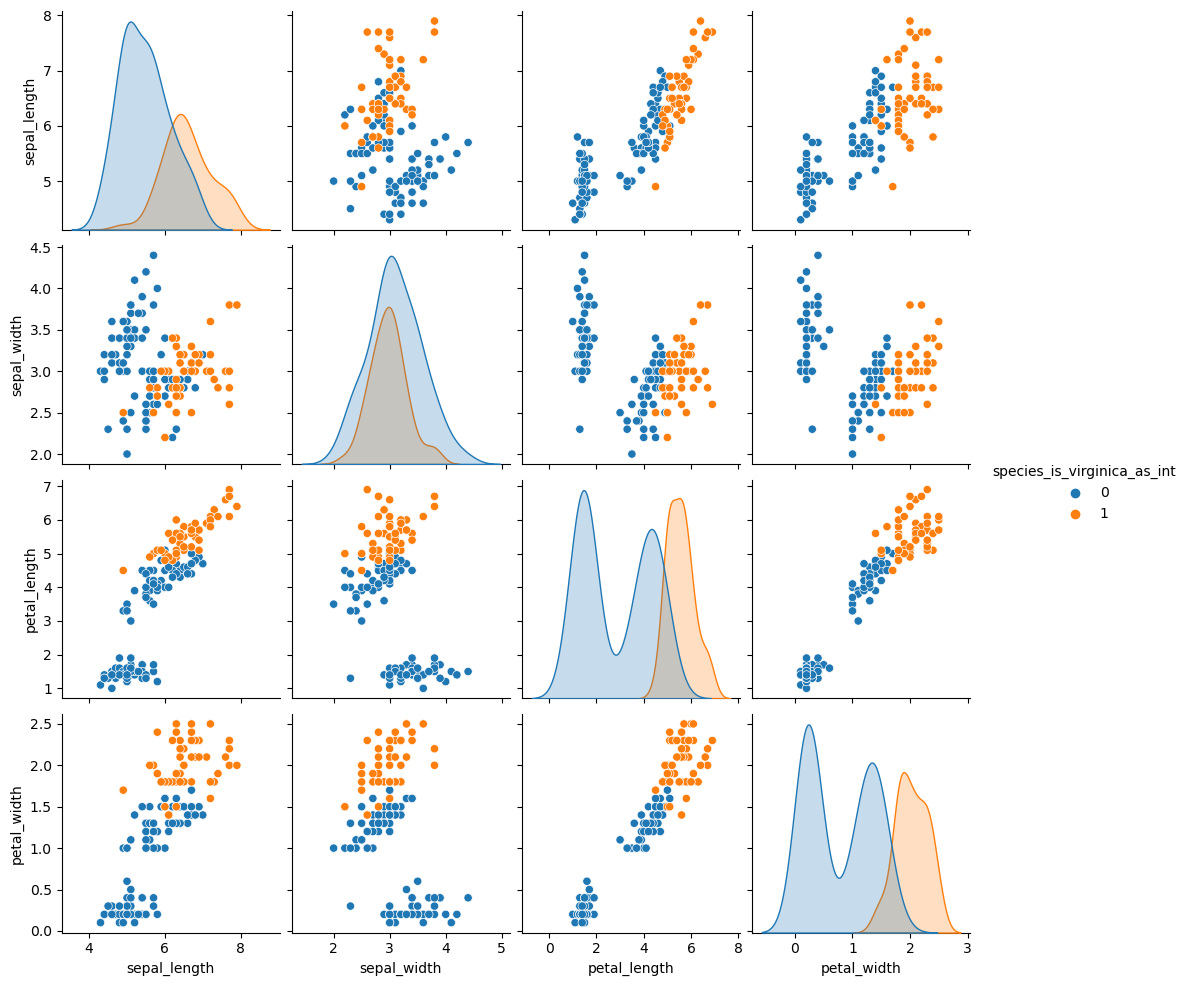

In [46]:
sns.pairplot(
    iris.drop(columns="species_is_virginica"),
    hue="species_is_virginica_as_int",
)

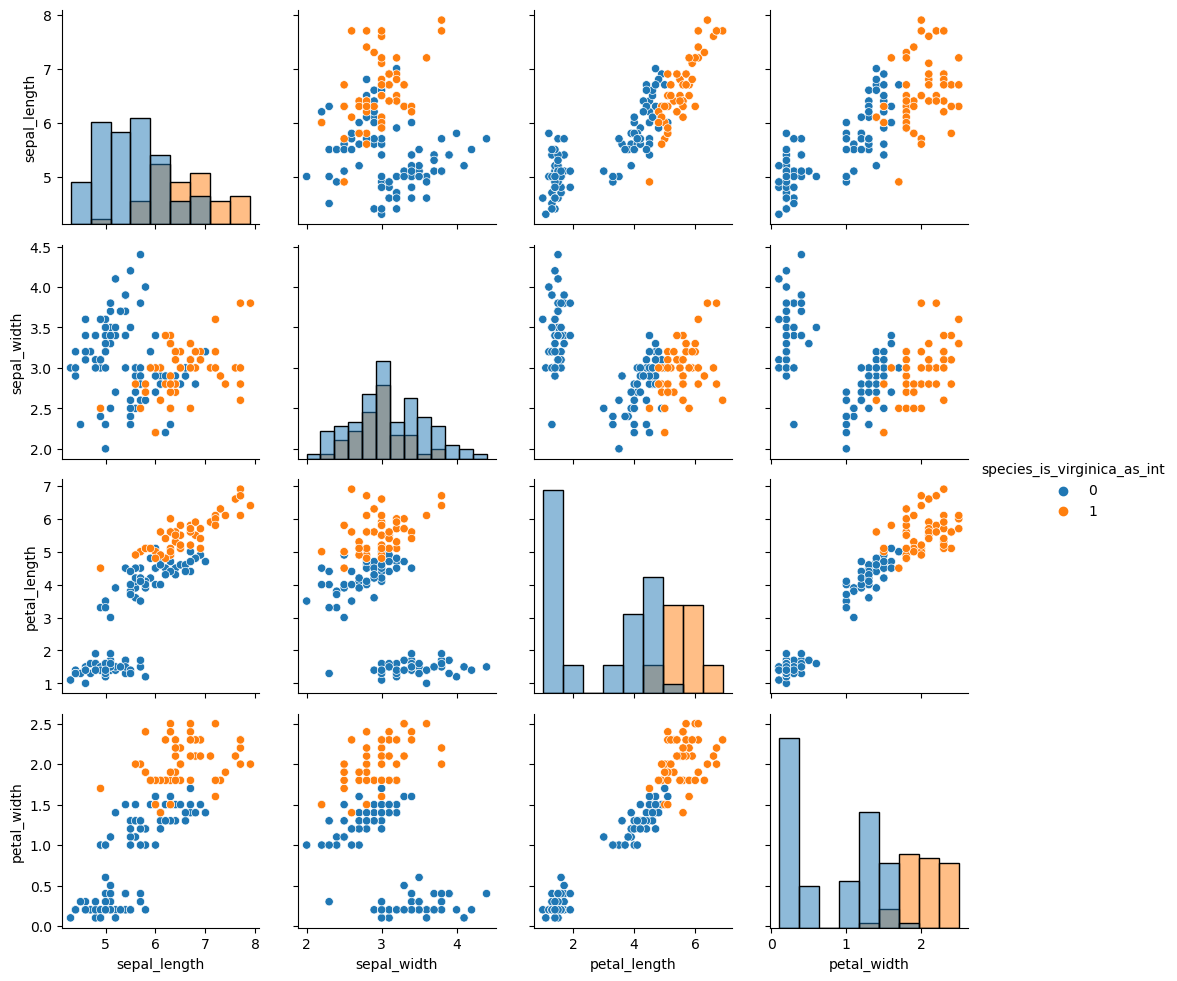

In [23]:
g = sns.PairGrid(
    iris.drop(columns="species_is_virginica"),
    hue="species_is_virginica_as_int",
)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

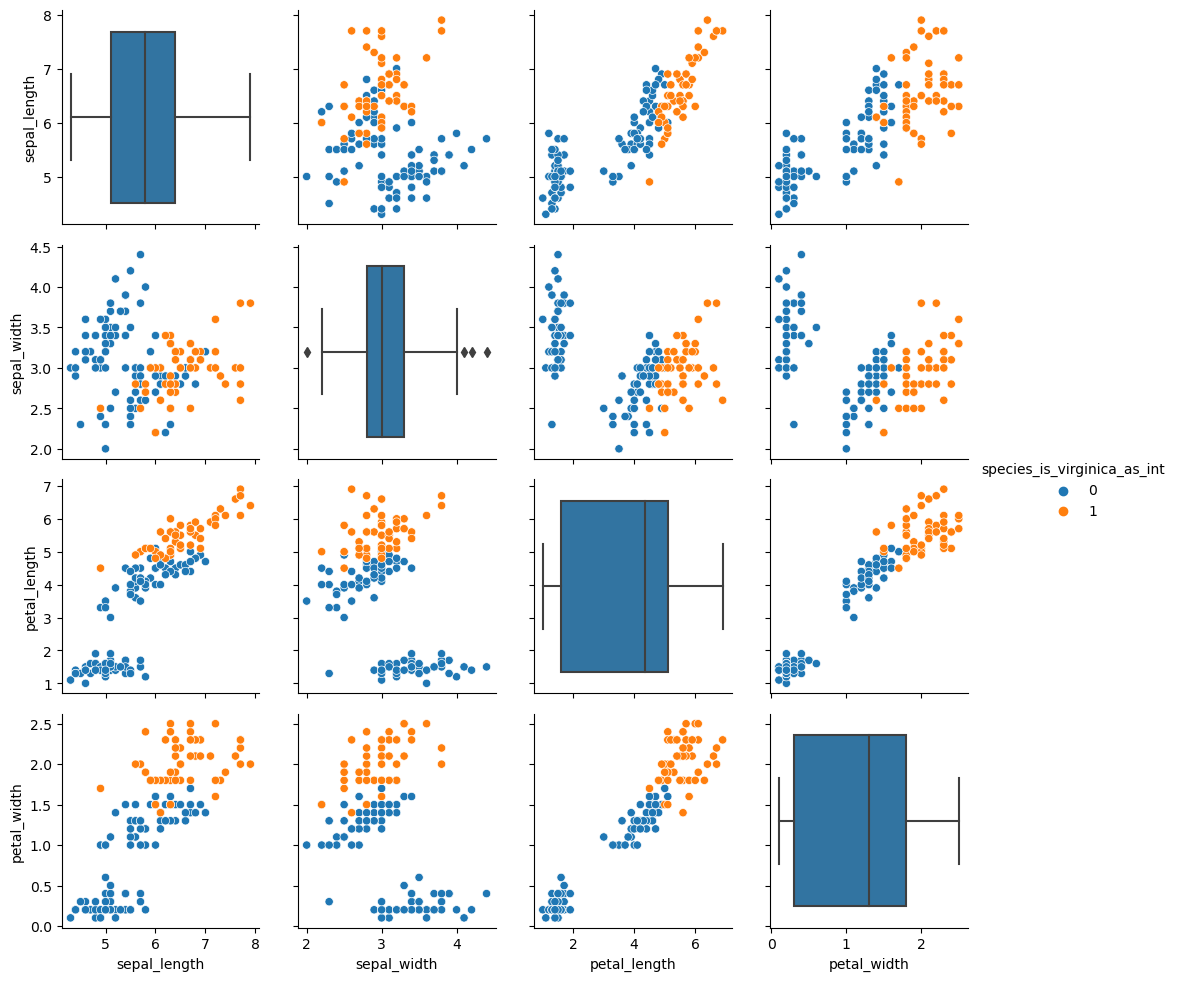

In [24]:
g = sns.PairGrid(
    iris.drop(columns="species_is_virginica"),
    hue="species_is_virginica_as_int",
)
g.map_diag(sns.boxplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

# FEATURE ENGINEERING/SCALING/SELECTION

Engineering:
* E.g. `df["date"].dt.year` can be encoded as one-hot categorical (to capture time-fixed effects i.e. a different intercept for each year -- just make sure not to include a global intercept term or you'll have perfect multicollinearity i.e. an underidentified optimization problem i.e. no unique solution -- easy to interpret dropping the global intercept though) or ordinal (to capture long-term linear trends)
* E.g. `df["date"].dt.month` can be encoded as one-hot categorical to capture seasonality (a different intercept per month -- just make sure you drop one
* E.g. Polynomial terms
* E.g. Interaction terms (but be careful -- you can interact one-hot categorical features with other "regular" terms if you really want to be able to estimate a different slope per category when there's intuition for this, but if it starts getting crazy, consider a non-parametric (e.g. tree-based) model)

Scaling (not really necessary for e.g. un-regularized OLS or tree-based models, but important for e.g. LASSO/Ridge (want to penalize coefficients on the same footing) or kNN (distance-based model) or deep learning):
* Can use min-max scaling
* Can use normalization/standardization (I've seen that this helps with training convergence for logistic regression i.e. GLM with the logit link function)

Selection:
* Can be done via PCA (choose top-n features)
* Can be done via LASSO

In [29]:
y = iris["species_is_virginica_as_int"]
y.head()

0    0
1    0
2    0
3    0
4    0
Name: species_is_virginica_as_int, dtype: int64

In [27]:
X = iris[
    [
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
    ]
]
X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=42,
)

In [32]:
standard_scaler = StandardScaler()
X_train_standard = standard_scaler.fit_transform(X_train)
X_test_standard = standard_scaler.transform(X_test)

In [48]:
# doing on just X_train bc not all methods may need to downsample features at start
pca = PCA()
pca.fit(X_train_standard)
pca.explained_variance_ratio_

array([0.71581797, 0.23720827, 0.04188112, 0.00509264])

# ORDINARY LINEAR REGRESSION

In [50]:
ols_reg = LinearRegression()
ols_reg.fit(X=X_train_standard, y=y_train)

LinearRegression()

In [51]:
y_pred_proba_ols_reg = ols_reg.predict(X_test_standard)

np.round(
    y_pred_proba_ols_reg,
    2,
)

array([ 0.3 , -0.01,  0.79,  0.47,  0.37, -0.05,  0.35,  0.87,  0.3 ,
        0.26,  0.77, -0.25, -0.13, -0.23,  0.01,  0.59,  0.85,  0.18,
        0.36,  0.8 , -0.14,  0.64, -0.02,  0.75,  0.88,  0.86,  0.54,
        0.93, -0.15, -0.17, -0.08,  0.16,  0.42, -0.1 , -0.14,  0.57,
        0.51, -0.11])

# LOGISTIC REGRESSION

In [36]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X=X_train_standard, y=y_train)

LogisticRegression(random_state=42)

In [52]:
y_pred_proba_log_reg = log_reg.predict_proba(X_test_standard)[
    # all rows
    :,
    # just proba for class=1
    1,
]

np.round(
    y_pred_proba_log_reg,
    2,
)

array([0.14, 0.  , 1.  , 0.24, 0.3 , 0.  , 0.04, 0.93, 0.45, 0.05, 0.77,
       0.  , 0.  , 0.  , 0.  , 0.28, 0.96, 0.05, 0.14, 0.96, 0.  , 0.59,
       0.  , 0.94, 0.92, 0.94, 0.91, 0.97, 0.  , 0.  , 0.  , 0.  , 0.15,
       0.  , 0.  , 0.83, 0.19, 0.  ])

In [40]:
y_pred_log_reg = log_reg.predict(X_test_standard)
y_pred_log_reg

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [41]:
accuracy_score(y_true=y_test, y_pred=y_pred_log_reg)

1.0